### BEAM PROFILE - TELESCOPING LENS SYSTEM

1st lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2

2nd lens (plano-convex): LA1461-C, F = 249.2mm, BFL = 247.4 

3rd lens (plano-convex): LA1951-C, F = 25mm, BFL = 17.6mm

Found beam waist before the lens: Waist x = 4.241 mm, Waist y = 3.84 mm
q1 (after first lens): -50.00+0.05j
q2 (before second lens): 250.00+0.05j
q3 (after second lens): -1500.00+1205087.21j
q4 (before third lens at z = 441 mm): -1359.00+1205087.21j
q5 (after third lens): -25.00000+0.00052j
z = 20 mm, Waist_x = 2.599 mm, Waist_y = 2.404 mm
z = 30 mm, Waist_x = 1.773 mm, Waist_y = 1.558 mm
z = 40 mm, Waist_x = 0.934 mm, Waist_y = 0.799 mm
z = 50 mm, Waist_x = 0.106 mm, Waist_y = 0.096 mm
z = 60 mm, Waist_x = 0.830 mm, Waist_y = 0.777 mm
z = 70 mm, Waist_x = 1.483 mm, Waist_y = 1.384 mm
z = 80 mm, Waist_x = 2.106 mm, Waist_y = 1.982 mm
z = 90 mm, Waist_x = 2.945 mm, Waist_y = 2.818 mm
z = 100 mm, Waist_x = 3.907 mm, Waist_y = 3.704 mm
z = 110 mm, Waist_x = 4.456 mm, Waist_y = 4.245 mm
z = 120 mm, Waist_x = 5.235 mm, Waist_y = 4.883 mm
z = 130 mm, Waist_x = 6.117 mm, Waist_y = 5.763 mm
z = 140 mm, Waist_x = 6.814 mm, Waist_y = 6.386 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
  Min Wais

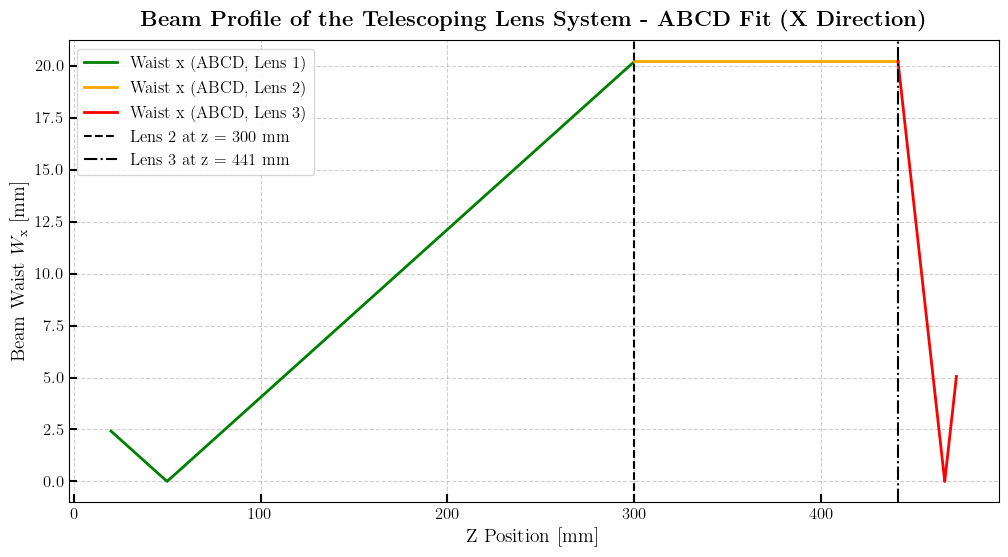

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_three_lenses.png


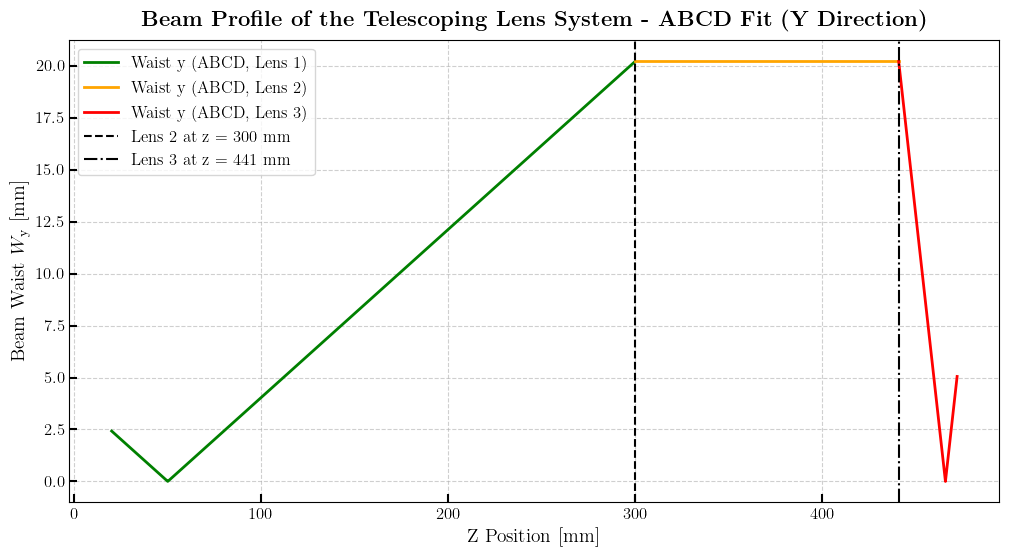

In [33]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50.0
focal_length2 = 250.0  
focal_length3 = 25.0 
wavelength = 1.064e-3
z_lens2 = 300  
z_lens3 = 441 

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens
print(f"q1 (after first lens): {q1:.2f}")

# Propagate to second lens position 
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)
print(f"q2 (before second lens): {q2:.2f}")

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
print(f"q3 (after second lens): {q3:.2f}")

# Propagate to third lens position 
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
print(f"q5 (after third lens): {q5:.5f}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 1000) # initial pts: 500
z_theoretical2 = np.linspace(z_lens2, z_lens3, 1000) # initial pts: 500
#z_theoretical3 = np.linspace(z_lens3, z_lens3 + focal_length3*1.25, 1000) # initial pts: 600
# Finer grid around the expected focal point
z_focal_expected = z_lens3 + focal_length3 
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 5, 1000),
    np.linspace(z_focal_expected - 5, z_focal_expected + 5, 10000), 
    np.linspace(z_focal_expected + 5, z_lens3 + focal_length3 * 1.25, 1000)
])
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")

# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1) 
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2) 
min_waist_theo3 = min(W_theoretical3[~np.isnan(W_theoretical3)]) * 1000
max_waist_theo3 = max(W_theoretical3[~np.isnan(W_theoretical3)])

# Theoretical focal position after the third lens
min_waist_theo3_idx = np.argmin(W_theoretical3[~np.isnan(W_theoretical3)])
z_focal_theo3 = z_theoretical3[~np.isnan(W_theoretical3)][min_waist_theo3_idx]

print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f"  Min Waist X: {min_waist_exp_x:.2f} μm")
print(f"  Min Waist Y: {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After Lens 1):")
print(f"  Min Waist: {min_waist_theo1:.2f} μm")
print(f"  Max Waist: {max_waist_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f"  Min Waist: {min_waist_theo2:.2f} mm")
print(f"  Max Waist: {max_waist_theo2:.2f} mm")
print(f"Theoretical (After Lens 3):")
print(f"  Min Waist: {min_waist_theo3:.2f} μm at z = {z_focal_theo3:.2f} mm")
print(f"  Max Waist: {max_waist_theo3:.2f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Scatter plot for experimental data from lens 1
#mask1 = z_values < 300
#plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
#plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

In [28]:
q4 = np.complex128(-1359 + 1205087.21j)
f3 = 25.0
A, B, C, D = np.float64(1), np.float64(0), np.float64(-1/f3), np.float64(1)
q5 = (A * q4 + B) / (C * q4 + D)
print(f"Recalculated q5: {q5:.5f}")

Recalculated q5: -25.00000+0.00052j
